In [10]:
%matplotlib notebook
import numpy as np
import matplotlib
from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotting_resources as res
import matplotlib.gridspec as gs
plt.rc('text', usetex=True)
plt.ion()

rauto_cut = 22.9
frauto_cut = 10**((rauto_cut-23.9)/(-2.5))

# Load the catalogs

In [2]:
slitcat = Table().read('../catalogs/personal_catalogs/slits_phot_zs_cutonslitdist_rcl.csv', format='csv')
ldpcat = slitcat[np.where((slitcat['Rauto'] < rauto_cut) & 
                          (slitcat['Q'] >= 4) & 
                          (slitcat['slit_distance'] < 1.0))]
cltable = res.load_clusters()
rfmags = Table().read('../catalogs/eazy_colors/ediscs_zldp_zfors_EAzY_outputs.csv', format='csv')
rfmags.rename_column('id', 'ids')

ldpcat = join(ldpcat, rfmags['ids','MAG_AB_rfB', 'MAG_AB_rfU'], keys='ids', join_type='left')
ldpcat['UB_color'] = ldpcat['MAG_AB_rfU'] - ldpcat['MAG_AB_rfB']

# Build the infall catalog

In [3]:
infallcat = Table()
for cl in cltable:
    infall = ldpcat[np.where((ldpcat['field'] == cl['tablename']) &
                             (abs(ldpcat['zLDP'] - cl['z']) < 0.02) &
                             (ldpcat['d_cl_mpc'] > cl['r200']) & 
                             (ldpcat['d_cl_mpc'] < cl['rinfall']))]
    infallcat = vstack([infallcat, infall])

# Build the control catalog

In [4]:
# Chose clusters to use
cltable.sort('z')
controlcls = cltable[0:1]

for cl in cltable:
    if cl['z'] > controlcls['z'][-1] + 0.04:
        controlcls.add_row(cl)

# Build the catalogs
controlcat = Table()
for cl in controlcls:
    for fcl in controlcls:
        subtable = ldpcat[np.where((ldpcat['field'] == fcl['tablename']) &
                                   (abs(ldpcat['zLDP']-fcl['z']) > 0.02) &
                                   (abs(ldpcat['zLDP']-cl['z']) < 0.02) &
                                   (ldpcat['d_cl_mpc'] > fcl['r200']) & 
                                   (ldpcat['d_cl_mpc'] < fcl['rinfall']))]
        subtable['field'] = cl['tablename']
        controlcat = vstack([controlcat, subtable])

# Calculate the fraction of objects that have a neighbor within $d_\theta$
For each cluster, calculate N_nn, N_tot. Once I do every cluster, I can calculate the fraction and error bar

In [5]:
def calc_frac_with_nn(catalog, dtheta, cl):
    n_nn = 0
    coords = SkyCoord(catalog['ra']*u.degree, catalog['dec']*u.degree)
    for obj in catalog:
        seps = SkyCoord(obj['ra']*u.degree, obj['dec']*u.degree).separation(coords).radian*cl['D_A']
        if sorted(seps)[1] < dtheta:
            n_nn += 1
    return n_nn, len(catalog)

def calc_uncert(sample, col, ntot):
    nnl = (sample[col] - res.lower_limit(sample[col]))
    
    upper = np.sqrt(((res.upper_limit(sample[col]) - sample[col])/ntot)**2 + 
                    (res.upper_limit(ntot) - ntot)**2*(sample[col]/ntot**2)**2)
    lower = np.sqrt(((sample[col] - res.lower_limit(sample[col]))/ntot)**2 + 
                    (res.lower_limit(ntot) - ntot)**2*(sample[col]/ntot**2)**2)
    sample['f_'+col[-1]+'_l'] = lower
    sample['f_'+col[-1]+'_u'] = upper
    return sample

In [6]:
def calc_all_fracs(input_cat, input_cltable):
    dtheta_list = [0.15, 0.2, 0.25, 0.3, 0.35]
    combined_sample = Table(names=('n_nn_a','n_nn_r','n_nn_b', 'dtheta'))

    # Calculate N for each bin dtheta bin
    for dtheta in dtheta_list:
        ndict = np.array([0, 0, 0])
        ntot_a, ntot_r, ntot_b = 0, 0, 0

        for cl in input_cltable:
            infall = input_cat[np.where(input_cat['field'] == cl['tablename'])]
            n_nn_a, ntot_ai = calc_frac_with_nn(infall, dtheta, cl)

            red, blue = res.add_red_blue(infall, cl)
            if len(red) > 1:
                n_nn_r, ntot_ri = calc_frac_with_nn(red, dtheta, cl)
            else:
                n_nn_r, ntot_ri = 0, len(red)

            if len(blue) > 1:
                n_nn_b, ntot_bi = calc_frac_with_nn(blue, dtheta, cl)
            else:
                n_nn_b, ntot_bi = 0, len(blue)
                
            ntot_a += ntot_ai
            ntot_r += ntot_ri
            ntot_b += ntot_bi
            ndict += [n_nn_a, n_nn_r, n_nn_b]

        combined_sample.add_row(np.append(ndict, dtheta))

    # Calculate the fractions and error bars
    combined_sample['f_r'] = combined_sample['n_nn_r']/ntot_r
    combined_sample = calc_uncert(combined_sample, 'n_nn_r', ntot_r)

    combined_sample['f_b'] = combined_sample['n_nn_b']/ntot_b
    combined_sample = calc_uncert(combined_sample, 'n_nn_b', ntot_b)

    combined_sample['f_a'] = combined_sample['n_nn_a']/ntot_a
    combined_sample = calc_uncert(combined_sample, 'n_nn_a', ntot_a)
    
    return combined_sample

In [7]:
cluster_sample = calc_all_fracs(infallcat, cltable)
control_sample = calc_all_fracs(controlcat, controlcls)

# Build the plot

In [11]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

errbar_args = {'lw':1.0, 'capsize': 3, 'elinewidth': 0.5, 'capthick': 0.5, 'markersize':4}
legend_args = {'fontsize': 10, 'frameon': False, 'loc':2}

<IPython.core.display.Javascript object>


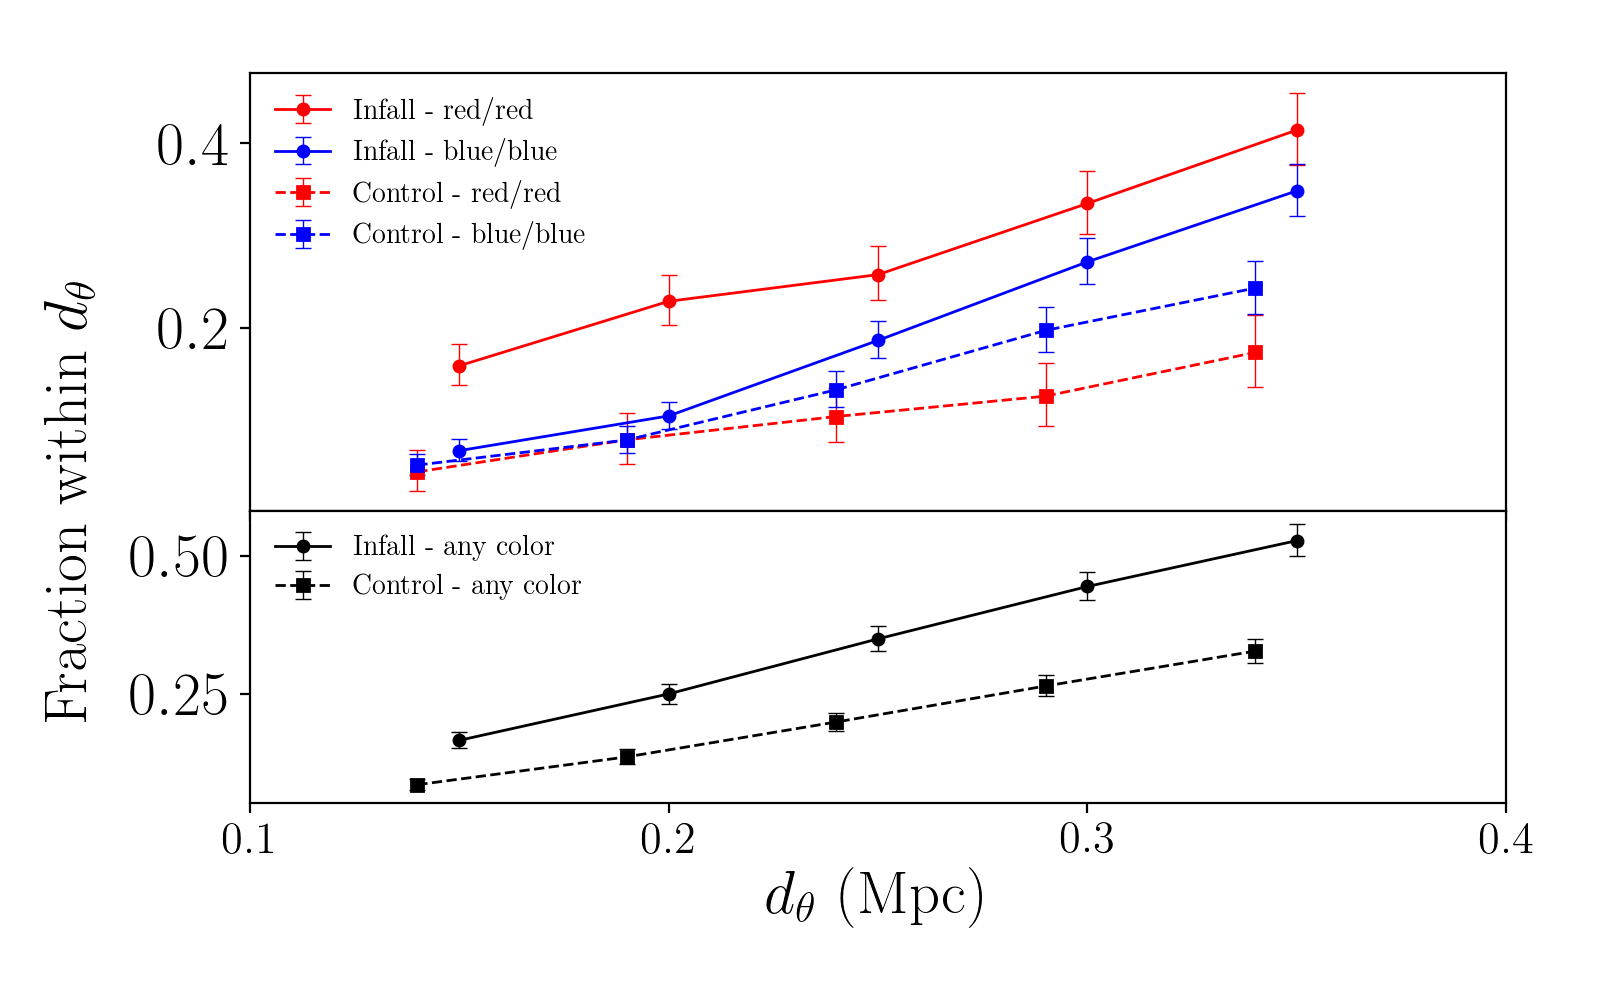

In [12]:
fig = plt.figure(figsize=(8, 5))
outer = gs.GridSpec(10, 1, hspace=0)
a1 = plt.subplot(outer[:6])
a2 = plt.subplot(outer[6:])


# Make the top plot
a1.errorbar(cluster_sample['dtheta'], cluster_sample['f_r'], fmt='-or', label=r'Infall - red/red',
            yerr=[cluster_sample['f_r_l'], cluster_sample['f_r_u']],
            **errbar_args)
a1.errorbar(cluster_sample['dtheta'], cluster_sample['f_b'], fmt='-ob', label=r'Infall - blue/blue',
            yerr=[cluster_sample['f_b_l'], cluster_sample['f_b_u']],
            **errbar_args)
a1.errorbar(control_sample['dtheta']-0.01, control_sample['f_r'], fmt='--sr', label=r'Control - red/red',
            yerr=[cluster_sample['f_r_l'], cluster_sample['f_r_u']],
            **errbar_args)
a1.errorbar(control_sample['dtheta']-0.01, control_sample['f_b'], fmt='--sb', label=r'Control - blue/blue',
            yerr=[cluster_sample['f_b_l'], cluster_sample['f_b_u']],
            **errbar_args)

# Format the top plot
a1.set_xticks([0.1, 0.2, 0.3, 0.4])
a1.set_xticklabels([]);
#a1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
#a1.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4], fontsize=16)
a1.legend(**legend_args)


# Make the bottom plot
a2.errorbar(cluster_sample['dtheta'], cluster_sample['f_a'], fmt='-ok', label=r'Infall - any color',
            yerr=[cluster_sample['f_a_l'], cluster_sample['f_a_u']],
            **errbar_args)
a2.errorbar(control_sample['dtheta']-.01, control_sample['f_a'], fmt='--sk', label=r'Control - any color',
            yerr=[control_sample['f_a_l'], control_sample['f_a_u']],
            **errbar_args)

# Format the bottom plot
a2.set_xticks([0.1, 0.2, 0.3, 0.4])
a2.set_xticklabels([0.1, 0.2, 0.3, 0.4], fontsize=16);
#a2.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
#a2.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4], fontsize=16)
a2.legend(**legend_args)
a2.set_xlabel(r'$d_\theta$ (Mpc)')

fig.text(0.05, 0.5, r'Fraction within $d_\theta$', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.04,0,1,1])

In [14]:
plt.savefig('plots/frac_neighbors.eps', dpi=800)

# Plot the red fraction in each bin for various samples

In [15]:
def calc_red_frac(nred, nblue):
    ntot = nred+nblue
    
    redfrac = nred/(ntot)
    upper = np.sqrt((res.upper_limit(nred)-nred)**2*(1./ntot - nred/ntot**2)**2 + 
                    (res.upper_limit(nblue)-nblue)**2*(nred/ntot**2)**2)
    lower = np.sqrt((nred-res.lower_limit(nred))**2*(1./ntot - nred/ntot**2)**2 + 
                    (nblue-res.upper_limit(nblue))**2*(nred/ntot**2)**2)
    
    return redfrac, upper, lower

In [16]:
fig = plt.figure(figsize=(8, 5))
a1 = fig.gca()

# Infall obj with neighbors
redfrac, upper, lower = calc_red_frac(cluster_sample['n_nn_r'], cluster_sample['n_nn_b'])
a1.errorbar(cluster_sample['dtheta'], redfrac, fmt='-ok', label=r'Infall - with neighbor',
            yerr=[lower, upper],
            **errbar_args)
# Infall obj without neighbors
redfrac, upper, lower = calc_red_frac((cluster_sample['n_nn_r']/cluster_sample['f_r'])-cluster_sample['n_nn_r'],
                                      (cluster_sample['n_nn_b']/cluster_sample['f_b'])-cluster_sample['n_nn_b'])
a1.errorbar(cluster_sample['dtheta'], redfrac, fmt='-ok', label=r'Infall - without neighbor',
            yerr=[lower, upper],
            **errbar_args, mfc='white')

# Control obj with neighbors
redfrac, upper, lower = calc_red_frac(control_sample['n_nn_r'], control_sample['n_nn_b'])
a1.errorbar(control_sample['dtheta']-.01, redfrac, fmt='--sk', label=r'Control - with neighbor',
            yerr=[lower, upper],
            **errbar_args)
# Control obj without neighbors
redfrac, upper, lower = calc_red_frac((control_sample['n_nn_r']/control_sample['f_r'])-control_sample['n_nn_r'],
                                      (control_sample['n_nn_b']/control_sample['f_b'])-control_sample['n_nn_b'])
a1.errorbar(control_sample['dtheta']-.01, redfrac, fmt='--sk', label=r'Control - without neighbor',
            yerr=[lower, upper],
            **errbar_args, mfc='white')




a1.legend(**legend_args)

a1.set_ylim([0.2,.85])

a1.set_ylabel(r'Red Fraction within $d_\theta$')
a1.set_xlabel(r'$d_\theta$ (Mpc)')
plt.tight_layout()

In [17]:
plt.savefig('plots/redfrac_neighbors.eps', dpi=800)